# Compare TF Statistics across Fuji, and Guadalupe, and DESI Y1

Using the redshifts of Tully-Fisher targets extracted from the [redshift database on NERSC], apply some simple quality cuts and plot some statistics of the Fuji, Guadalupe, and DESI Y1 MAIN samples.

All redshifts for the Tully-Fisher analysis are available in the folder `/global/project/projectdirs/desi/science/td/pv`.

To dos:
- Clean up output of image cutouts so that not so many files are dumped into the `_cache` folder.
- Add extraction and plotting of TF spectra in the cutouts.

In [1]:
from desispec.io import read_spectra, write_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

import redrock.templates

rrtemplates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    rrtemplates[(t.template_type, t.sub_type)] = t

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, vstack, hstack, join, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from datetime import datetime, timedelta

from scipy.ndimage import gaussian_filter1d

import os
from glob import glob

import psycopg2

from tqdm.notebook import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [2]:
mpl.rc('font', size=14)

## Common Plotting Functions and Catalog Cuts

In [3]:
def firstdigit(n):
    """Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    return np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)

def plot_radec(ra, dec):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(120 - ra)
    _ra[_ra < -np.pi] += 2*np.pi
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, alpha=0.5, s=2)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['270', '240', '210', '180', '150', '120', '90', '60', '30', '0', '330'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

import requests

def get_cutout(targetid, ra, dec, width=300, height=300, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    os.makedirs('_cache', exist_ok=True)
    img_name = f'_cache/cutout_{targetid}_{width}_{height}.jpg'
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&%22/pix=0.25&layer=ls-dr9&width={width}&height={height}&sga'
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.25/3600,
        'CRPIX1': width//2,
        'CRVAL1': ra,
        'NAXIS1': width,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.25/3600,
        'CRPIX2': height//2,
        'CRVAL2': dec,
        'NAXIS2': height
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [4]:
def clean_catalog(data):
    """Take a catalog matched to PV TF targets and apply quality cuts:
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25)
    * Ensure 1 main DESI TARGETID per SGA_ID
    * Ensure >1 distinct TARGETIDs per SGA_ID
    * Ensure targets are not all spatially coincident.
    
    Parameters
    ----------
    data : astropy.Table
        Table of TF redshift measurements and matched SGA_IDs.
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for Tully-Fisher analysis, after basic cuts.
    """
    # All targets
    _ids_all, _counts_all = np.unique(tfuji['SGA_ID'], return_counts=True)

    # Identify targets with good redshifts.
    isgoodz = (data['ZWARN']==0) & (data['DELTACHI2']>=25)
    _ids_goodz, _counts_goodz = np.unique(data['SGA_ID'][isgoodz], return_counts=True)

    # Select SGA_IDs with at least 2 good associated redshifts.
    select = np.in1d(data['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
    data = data[select].group_by('SGA_ID')

    # Storage for output.
    data_tf = None

    # Loop through the table and keep only SGA IDs with >= 2 unique TARGETIDs, where one is a MAIN survey target.
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate(sga_ids):
            progress_bar.update(1)
            tab = data[data['SGA_ID']==sga_id]

            # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
            digits = firstdigit(tab['TARGETID'])
            if np.any(digits == 3):
                maintargetids = np.unique(tab['TARGETID'][digits==3].value)

                # Ensure there are at least two distinct TARGETIDs matched to this SGA_ID.
                ntargets = len(np.unique(tab['TARGETID'].value))
                if ntargets >= 2:

                    # Ensure the TARGETIDs correspond to distinct locations on the sky.
                    coords = SkyCoord(tab['TARGET_RA'], tab['TARGET_DEC'], frame='icrs', unit='degree')
                    is_distinct = np.any([c1.separation(c2).to_value('arcsec') > 1 for c1 in coords for c2 in coords])
                    if not is_distinct:
                        continue
                # Check that there two or more TARGETIDs.
                else:
                    continue
            # Check that there is a MAIN survey TARGETID associated with this SGA_ID.
            else:
                continue

            if data_tf is None:
                data_tf = tab
            else:
                data_tf = vstack([data_tf, tab])

    return data_tf

## Fuji: SV1, SV2, SV3

In [5]:
tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


### Targets grouped by SGA_ID

Find all targets with at least 2 observations per SGA_ID.

In [6]:
# All targets
_ids_all, _counts_all = np.unique(tfuji['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

123
848
896
1548
1583
1980
2497
3727
5288
5732
5958


In [7]:
# All targets with decent redshifts and observations suitable for the Tully-Fisher analysis
tfuji_tf = clean_catalog(tfuji)
_ids_goodz, _counts_goodz = np.unique(tfuji_tf['SGA_ID'], return_counts=True)
_ids_goodz[_counts_goodz > 1]

  0%|          | 0/1372 [00:00<?, ?it/s]

896
1548
1583
1980
2497
5732
5958
5964
8032
9519
9769


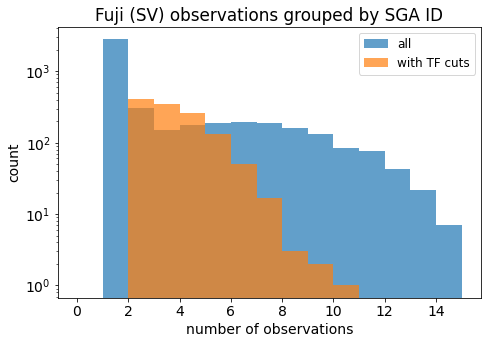

In [8]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='with TF cuts')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='Fuji (SV) observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right')

fig.savefig('desi_pv_tf_fuji_sga_hist.png', dpi=120)

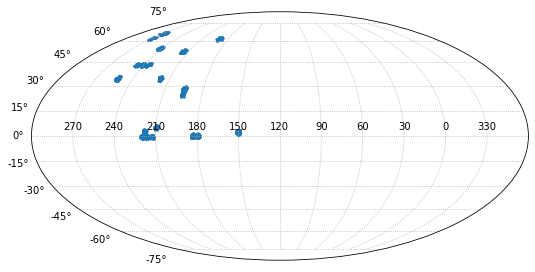

In [9]:
fig = plot_radec(tfuji_tf['TARGET_RA'], tfuji_tf['TARGET_DEC'])
fig.savefig('desi_pv_tf_fuji_radec.png', dpi=120)

### Save Fuji Tully-Fisher Sample

#### Output Fuji TF Sample

In [10]:
tfuji_tf.write('desi_pv_fuji_tf_redshifts.fits', overwrite=True)

#### Plot Observations of SGA Objects

  0%|          | 0/1225 [00:00<?, ?it/s]

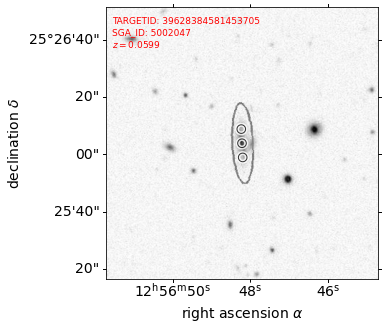

In [11]:
sga_ids = np.unique(tfuji_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tfuji_tf[tfuji_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tf_fuji_{maintargetid}.png', dpi=120)

## Guadalupe

### Main survey + special BRIGHT tiles

During poor observing conditions the DESI NTS switches from MAIN observing to a special BRIGHT program. For now, keep both sets of observations and use them in the TF sample.

In [12]:
tguad = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_guadalupe_healpix.fits')
tguad = unique(tguad[tguad['SURVEY']=='main'])
tguad

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes7,float64,float64,int64,float64,bytes76,bytes3,int64,float64,float64
-211637396,214.408367861604,38.1654319218372,10550,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/bright/105/10550/redrock-main-bright-10550.fits,TFT,908460,214.40820991032487,38.1654315747636
-205733115,193.87126208164,-7.79797192944254,25775,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/bright/257/25775/redrock-main-bright-25775.fits,EXT,1232665,193.8711697701549,-7.797829020837202
-204141114,256.286226415617,7.99070771912205,31568,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/bright/315/31568/redrock-main-bright-31568.fits,SGA,1127864,256.2861272736802,7.990563879458973
-21951418,216.243322559367,35.3508295804599,10515,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/105/10515/redrock-main-dark-10515.fits,TFT,1287197,216.24324832697206,35.350942322499904
-21637396,214.408354412019,38.1654094359474,10550,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/dark/105/10550/redrock-main-dark-10550.fits,TFT,908460,214.40820991032487,38.1654315747636
-15733115,193.871320929678,-7.79798768021886,25775,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/257/25775/redrock-main-dark-25775.fits,EXT,1232665,193.8711697701549,-7.797829020837202
-14141114,256.286208378824,7.99067911276296,31568,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/315/31568/redrock-main-dark-31568.fits,SGA,1127864,256.2861272736802,7.990563879458973
2389323404017665,193.169799009602,-8.46115859313254,25774,main,0.612075359942603,0.000107336452958421,4,1.78085574880242,guadalupe/healpix/main/bright/257/25774/redrock-main-bright-25774.fits,TFT,777502,193.1697990096016,-8.46115859313254
2389323420794881,194.205241963782,-8.49518775732336,25773,main,0.915675363293589,9.8920195886762e-05,4,6.3497832682915,guadalupe/healpix/main/bright/257/25773/redrock-main-bright-25773.fits,TFT,1097079,194.2052419637823,-8.495187757323357


### Targets grouped by SGA_ID

In [13]:
# All targets
_ids_all, _counts_all = np.unique(tguad['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

1787
22240
26839
36408
81410
81587
87500
97758
101426
103331
125443


In [14]:
# All targets with decent redshifts and observations suitable for the Tully-Fisher analysis
tguad_tf = clean_catalog(tguad)
_ids_goodz, _counts_goodz = np.unique(tguad_tf['SGA_ID'], return_counts=True)
_ids_goodz[_counts_goodz > 1]

  0%|          | 0/102 [00:00<?, ?it/s]

22240
26839
36408
81410
87500
97758
101426
103331
125443
126180
149185


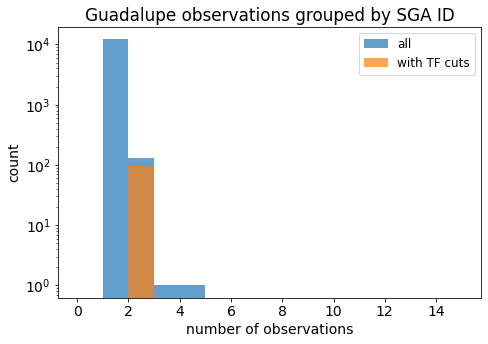

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='with TF cuts')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='Guadalupe observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right')

fig.savefig('desi_pv_tf_guadalupe_sga_hist.png', dpi=120)

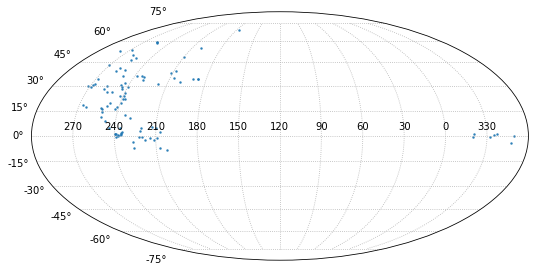

In [16]:
fig = plot_radec(tguad_tf['TARGET_RA'], tguad_tf['TARGET_DEC'])
fig.savefig('desi_pv_tf_guad_radec.png', dpi=120)

### Save Guadalupe Tully-Fisher Sample

#### Write Redshift Catalog to Disk

In [17]:
tguad_tf.write('desi_pv_guadalupe_tf_redshifts.fits', overwrite=True)

#### Plot Cutouts of SGA Objects 

  0%|          | 0/95 [00:00<?, ?it/s]

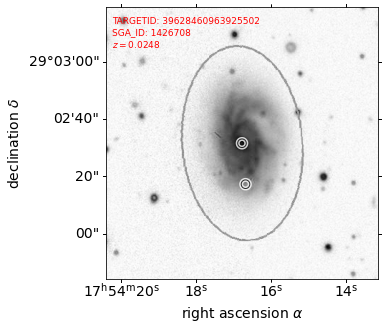

In [18]:
sga_ids = np.unique(tguad_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tguad_tf[tguad_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            print(f'No MAIN (SGA) target for {sga_id}?')
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tf_guadalupe_{maintargetid}.png', dpi=120)

## Check MAIN Survey PV TF Targets against Daily Reduction

Access the daily *tiles* redshifts database to cover the part of Y1 not in the Guadalupe sample. Note that this means the redshifts are going to belong to a mixture of the `everest` and `fuji/guadalupe` reductions.

Cut on DESI Y1 to remove the SV data already saved in the Fuji tables: 20210514 - 20220514.

In [19]:
tdaily = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_daily_tiles.fits')
tdaily = unique(tdaily[(tdaily['NIGHT'] > 20210513) & (tdaily['NIGHT'] < 20220514)])
tdaily

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64
-411444222,156.21815002209,7.15848284808457,41144,20220504,0.102479475013216,8.66839004506941e-05,2053,0.394602766493335,daily/tiles/cumulative/41144/20220504/redrock-4-41144-thru20220504.fits,TFT,4614,156.21810707253144,7.1582430702316175
-256075243,267.712765090224,29.4851124724098,25607,20220504,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/25607/20220504/redrock-5-25607-thru20220504.fits,SGA,447725,267.7127798938763,29.484990855307803
-255474428,318.116492659747,-5.28401899381209,25547,20211021,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/25547/20211021/redrock-4-25547-thru20211021.fits,TFT,342501,318.1167585749797,-5.283990383719008
-236269010,159.441551301486,11.8164401561333,23626,20220103,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/23626/20220103/redrock-9-23626-thru20220103.fits,SGA,112426,159.44167440686755,11.816368587372878
-220511122,158.609359755658,4.10129785830121,22051,20220420,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/22051/20220420/redrock-1-22051-thru20220420.fits,TFT,1285714,158.60939980220817,4.1014249139344905
-215282046,135.381709169741,2.89942982211333,21528,20220307,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21528/20220307/redrock-2-21528-thru20220307.fits,TFT,730406,135.38157955417336,2.8996065765603865
-215264164,139.654305794728,0.327220629540815,21526,20220125,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21526/20220125/redrock-4-21526-thru20220125.fits,SGA,460051,139.65430588469135,0.32746260142544686
-204834222,156.218107863433,7.15848293358231,20483,20220423,-0.00199570145091582,4.13115987161332e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/20483/20220423/redrock-4-20483-thru20220423.fits,TFT,4614,156.21810707253144,7.1582430702316175
-115015155,187.763020229623,0.048940228168639,11501,20220209,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/11501/20220209/redrock-5-11501-thru20220209.fits,TFT,1202979,187.7631083263793,0.04896332744150247


### Targets grouped by SGA_ID

Apply standard cleanup.

To do: double-check that the cuts are not too conservative and toss out observations useful for the TF analysis.

In [20]:
# All targets
_ids_all, _counts_all = np.unique(tdaily['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

55
94
117
223
242
316
425
454
581
731
783


In [21]:
# All targets with decent redshifts and observations suitable for the Tully-Fisher analysis
tmain_tf = clean_catalog(tdaily)
_ids_goodz, _counts_goodz = np.unique(tmain_tf['SGA_ID'], return_counts=True)
_ids_goodz[_counts_goodz > 1]

  0%|          | 0/14293 [00:00<?, ?it/s]

55
117
223
581
731
1135
1158
1287
1289
1358
1663


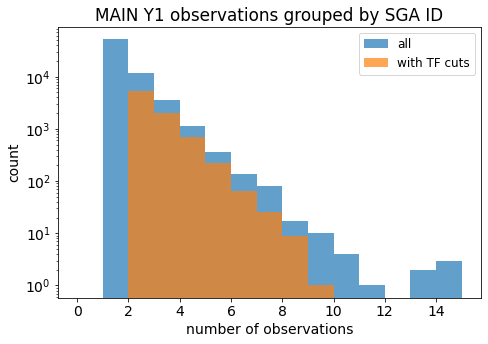

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='with TF cuts')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='MAIN Y1 observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right')

fig.savefig('desi_pv_tf_y1main_sga_hist.png', dpi=120)

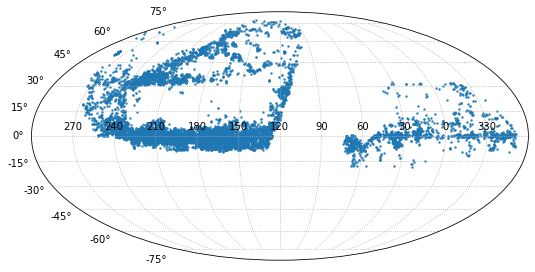

In [23]:
fig = plot_radec(tmain_tf['TARGET_RA'], tmain_tf['TARGET_DEC'])
fig.savefig('desi_pv_tf_y1main_radec.png', dpi=120)

### Save MAIN Y1 Tully-Fisher Redshifts

Extract observations with a MAIN survey central target and at least 2 unique TARGETIDs per SGA_ID.

#### Write TF MAIN Redshifts to Disk

In [24]:
tmain_tf.write('desi_pv_y1main_tf_redshifts.fits', overwrite=True)

#### Plot MAIN Y1 TF Cutouts

Caution: there are >8k observations in Y1 so this needs to be rewritten to not dump 8k images into a single folder. For now, just terminate the loop early.

  0%|          | 0/8243 [00:00<?, ?it/s]

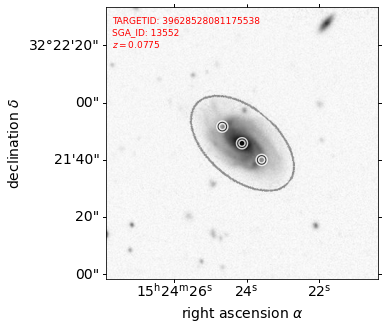

In [25]:
sga_ids = np.unique(tmain_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tmain_tf[tmain_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            print(f'No MAIN (SGA) target for {sga_id}?')
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tf_y1main_{maintargetid}.png', dpi=120)
        
        if i > 100:
            break